In [44]:
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
from random import random,randint
import numpy as np
from functools import reduce
from scipy.optimize import minimize
from scipy.linalg import expm,sinm,cosm
import cvxopt as cvx
import cvxopt.lapack
import time
import math
from   matplotlib import cm
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.quantum_info.analysis import average_data
from qiskit import *
from qiskit.quantum_info.operators import Operator
from qiskit.aqua.utils import tensorproduct
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from qiskit.providers.ibmq      import least_busy
from qiskit.tools.monitor       import job_monitor
from qiskit.visualization import plot_histogram
import picos as pic
import warnings
from docplex.mp.model import Model
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.algorithms import CplexOptimizer

warnings.filterwarnings('ignore')




# Generate random graph

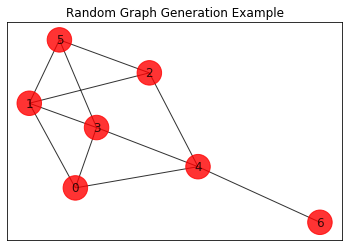

In [47]:
#Define some pauli operators
PauliX = [[0,1],[1,0]]   
PauliZ = [[1,0],[0,-1]]
PauliI = np.eye(2)

#Generate random graph
def ER(n, p):
    V = set([v for v in range(n)])
    E = set()
    for combination in combinations(V, 2):
        a = random()
        if a < p:
            E.add(combination)

    g = nx.Graph()
    g.add_nodes_from(V)
    g.add_edges_from(E)
    return g
#Define Cjk and B
def Cjk_generator(n,j,k):
    l = list(range(0,n))
    for i in range(n):
        l[i] = PauliI
    l[j] = PauliZ
    l[k] = PauliZ
    temp = l[0]
    for i in range(n-1):
        temp = np.kron(temp,l[i+1])
    Cjk = 0.5 * (-temp + np.eye(pow(2,n)))
    return Cjk
def B_generator(n):
    l = list(range(0,n))
    b = list(range(0,n))
    
    for a in range(n):
        for i in range(n):
            l[i] = PauliI
        l[a]=PauliX
        temp = l[0]
        for i in range(n-1):
            temp = np.kron(temp,l[i+1])
        b[a] = temp
    B = sum(b[a] for a in range(n))
    return B
#Construct initial state 
def init_s(n):
    x = pow(2,n)
    s = 1/np.sqrt(x) * np.ones(x)
    s = s.reshape(x, 1)
    return s

# auxilliary function to plot graphs
def plot_result(G, x):
    colors = ['r' if x[i] == 0 else 'b' for i in range(n)]
    pos, default_axes = nx.spring_layout(G), plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)

#Generate random graph
def ER(n, p):
    V = set([v for v in range(n)])
    E = set()
    for combination in combinations(V, 2):
        a = random()
        if a < p:
            E.add(combination)

    g = nx.Graph()
    g.add_nodes_from(V)
    g.add_edges_from(E)
    return g



n = 7
p = 0.6
G = ER(n, p)
pos = nx.spring_layout(G)
plot_result(G,[0]*n)
plt.title("Random Graph Generation Example") 
edges = G.edges
E = np.array(list(edges))




# Finding optimal angles with fine grid

Numbers of iteration:  3969

 Average expectation using QAOA with fine grid :  [[5.42228384]]

 Maximum expectation using QAOA with fine grid :  [[7.01870926]]

 Optimal gamma :  0.25

 Optimal beta :  1.9000000000000001

 Runningtime :  62.95411801338196


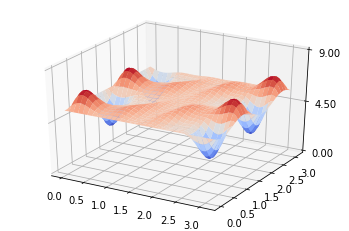

In [48]:
#Construct C from edges

Cjk=list(range(0,len(E)))

for i in range(len(E)):
    j = E[i][0]
    k = E[i][1]
    Cjk[i]=Cjk_generator(n,j,k)

C = sum(Cjk[a] for a in range(len(E)))
B = B_generator(n)
s = init_s(n)
s_d = (s).T


#run the program
start_time = time.time()
step_size   = 0.05
result_array = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))
a_gamma         = np.arange(0, np.pi, step_size)
a_beta          = np.arange(0, np.pi, step_size)
print("Numbers of iteration: ",(pow((int(3.14/step_size)+1),2)))
f_p_max = 0
f_p_max_gamma = 0
f_p_max_beta = 0
f_psum = 0

for i in range(0, int(3.14/step_size)+1):           # i for a_gamma
    for j in range(0, int(3.14/step_size)+1):       # j for a_beta
        
        #Construct U_C
        U_C = np.asmatrix(expm(-1j*2*a_gamma[i]*C))
        #Construct U_B
        U_B = expm(-1j*a_beta[j]*B)


        #Construct expection of each subgraph
        state = (U_B.dot(U_C)).dot(s).reshape(pow(2,n),1) # ket
        state_d = (state.conjugate()).T # bra
    
        
        f_p = (state_d.dot(C)).dot(state)
        f_psum += f_p
        
            
        if f_p.real > f_p_max:
            f_p_max = f_p.real
            f_p_max_gamma = a_gamma[i]
            f_p_max_beta = a_beta[j]
            
        result_array[i][j] = f_p.real
print("\n Average expectation using QAOA with fine grid : ",(f_psum/pow(len(a_gamma),2)).real)       
print("\n Maximum expectation using QAOA with fine grid : ",f_p_max)
print("\n Optimal gamma : ",f_p_max_gamma)
print("\n Optimal beta : ",f_p_max_beta)


end_time = time.time()
print("\n Runningtime : ",end_time - start_time)






# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

gamma = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))
beta = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))

for i in range(0, int(3.14/step_size)+1):
    for j in range(0, int(3.14/step_size)+1):
        gamma[i][j] = a_gamma[i]
        beta[i][j] = a_beta[j]



surf = ax.plot_surface(gamma, beta, result_array, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_zlim(0, np.ceil(f_p_max)+1)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

#The smallest parameters and the expectation can be extracted
#print('\n --- OPTIMAL PARAMETERS --- \n')
#print('The maximal expectation value is:  M1 = %.03f' ,% np.amax(f_p))
#print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))



# QAOA method with optimal angles


 --- SIMULATION RESULTS ---

The sampled mean value is M1_sampled = 4.87 while the true value is M1 = 7.02 

The approximate solution is x* = 0100110 with C(x*) = 9 



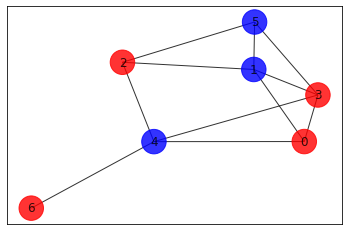

In [49]:
# prepare the quantum and classical resisters
QAOA = QuantumCircuit(n,n)

# apply the layer of Hadamard gates to all qubits
QAOA.h(range(n))
QAOA.barrier()

# apply the Ising type gates with angle gamma along the edges in E
for i in range(len(E)):
    j = E[i][0]
    k = E[i][1]
    QAOA.cu1(-2*f_p_max_gamma, j, k)
    QAOA.u1(f_p_max_gamma, j)
    QAOA.u1(f_p_max_gamma, k)
    
# then apply the single qubit X - rotations with angle beta to all qubits
QAOA.barrier()
QAOA.rx(2*f_p_max_beta, range(n))

# Finally measure the result in the computational basis
QAOA.barrier()
QAOA.measure(range(n),range(n))

### draw the circuit for comparison
QAOA.draw(output='mpl')


# Compute the value of the cost function
def cost_function_C(x,G):
    
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        C = C + x[e1]*(1-x[e2]) + x[e2]*(1-x[e1])
        
    return C
# run on local simulator
backend      = Aer.get_backend("qasm_simulator")
shots        = 10000

simulate     = execute(QAOA, backend=backend, shots=shots)
QAOA_results = simulate.result()

plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)  
# Evaluate the data from the simulator
counts = QAOA_results.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,f_p_max))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
plot_histogram(hist,figsize = (8,6),bar_labels = False)
resultq = np.array(list(max_C[0]),dtype = int)
plot_result(G,resultq)


   







# Compare wuth SDP

// This file has been generated by DOcplex
// model name is: MaxCut
// var contrainer section
dvar bool x[7];

maximize
 3 x0 + 4 x1 + 3 x2 + 4 x3 + 4 x4 + 3 x5 + x6 [ - 2 x0*x1 - 2 x0*x3 - 2 x0*x4
 - 2 x1*x2 - 2 x1*x3 - 2 x1*x5 - 2 x2*x4 - 2 x2*x5 - 2 x3*x4 - 2 x3*x5
 - 2 x4*x6 ];
 
subject to {

}
optimal function value: 9.0
optimal value: [1. 0. 1. 1. 0. 0. 1.]
status: SUCCESS


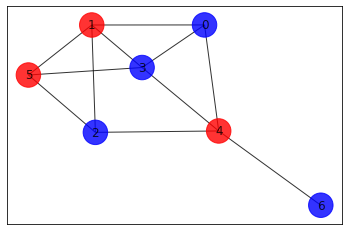

In [50]:
mdl = Model('MaxCut')
x = mdl.binary_var_list('x{}'.format(i) for i in range(n))

objective = mdl.sum([ (x[i] + x[j] - 2*x[i]*x[j]) for (i, j) in edges])
mdl.maximize(objective)

mdl.prettyprint()
# convert from DOcplex model to Qiskit Quadratic Program
qp = QuadraticProgram()
qp.from_docplex(mdl)

# Solve Quadratic Program using CPLEX
cplex = CplexOptimizer()
result = cplex.solve(qp)
print(result)
plot_result(G, result.x)